# Mollie Panter-Downes’ wartime stories: Territory Free of War 

This Jupyter Notebook assists the article "Mollie Panter-Downes’ wartime stories: Territory Free of War ". All the figures, present in the article are placed here with detailed explanations of their composition and methodology. Also, some additional digital instruments, which the article does not facilities, are placed here.

### Text Extraction and Processing

The text was extratced from scanned pages of the following edition:
Panter-Downes, Mollie. Good Evening, Mrs Craven: The Wartime Stories of Mollie Panter-Downes. Edited by Gregory Lestage. Reprinted. Persephone Classics. London: Persephone Books, 2008.
After the deliting the title page, Lestage's *Preface* and *Afterword*, table of content and two Letters from London (Panter-Downes' journalism), the text was OCR'ed (optical character recognition) with Tesseract tool. Txt-file of the 21 short stories were placed in a folder.

### Extracting basic statistical metrics of the collection

Launching necessary libraries

In [38]:
#%matplotlib widget
import os
import nltk
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
nltk.download('vader_lexicon')
from scipy.stats import zscore
from scipy.stats import pearsonr
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import Text
from nltk.corpus import stopwords
sentiment_analyzer = SentimentIntensityAnalyzer()
from tqdm import tqdm
import spacy
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner']) # Initialize spacy 'en' model, keeping only tagger component needed 
import gensim
import re
from semanticfield import war_semantic_field
from gensim.models import Word2Vec
import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/felix/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/felix/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/felix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The code for this extraction  is written in class TextAnalyzer, placed in a separate file.
TextAnalizer in severals methods can output:
1. list of tokenized words
2. number of words
3. average word length
4. list of sentence tokens
5. number of sentences
6. average sentence length in words
7. text, splitted into paragraphs
8. number of paragraphs
9. average paragraph length in words
10. average paragraph length in sentences
11. scores of VADER sentiment analysis of a text
12. list of lemmatized text's tokens
13. list of unique words
14. number of unique words
15. draw a plot of compound sentiment of a text
16. list of the mentioned above statistical metrics for text's compound table


In [39]:
from textanalyzer import TextAnalyzer, metrics

Reading txt files and extracting the statistical metrics

In [40]:
titles = os.listdir('/home/felix/Documents/my python projects/Mollie-Panter-Downes-wartime-short-stories/Good Evening, Mrs. Craven texts')
ordered_titles = sorted(titles, key=lambda t: int(t.split('. ')[0]))
all_texts_as_str = []
file_w = open ('text metrics.csv', mode = 'w', encoding='utf-8')
file_writer = csv.writer(file_w, delimiter = ";", lineterminator="\r")
file_writer.writerow(['title','number of words', 'number of sentences',
                    'number of unique words', 'number of paragraphs',
                    'average word length', 'average sentence length',
                    'average paragraph length in sentences',
                    'average paragraph length in words',
                    'sentiment negative', 'sentiment neutral',
                    'sentiment positive', 'sentiment compound'])
for title in tqdm(ordered_titles):
    f = open (f'Good Evening, Mrs. Craven texts/{title}', encoding='utf-8')
    short_story = f.read()
    all_texts_as_str.append(short_story)
    text_metrics = metrics(short_story)
    text_metrics.insert(0, title[:-4])
    file_writer.writerow(text_metrics)
    f.close()
file_w.close()

/home/felix/miniconda3/envs/mollie/lib/python3.12/site-packages/tqdm/std.py:465: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  if rate and total else datetime.utcfromtimestamp(0))
 24%|██▍       | 5/21 [00:00<00:01,  8.09it/s]

100%|██████████| 21/21 [00:04<00:00,  5.20it/s]


In [41]:
titles_for_graphs = ["Date with Romance", "Meeting at the Pringles'", "Mrs. Ramsay's War", "In Clover", " It's the Real Thing...",
                     "This Flower, Safety", "As the Fruitful Vine", "Lunch with Mr. Biddle", "Battle of the Greeks",
                     "Fin de Siècle", "Literary Scandal...", "Goodbye, My Love", "War Among Strangers", "Combined Operations",
                     "Good Evening, Mrs. Craven", "The Hunger of Miss Burton", "It's the Reaction", "Cut down the Trees",
                     "Year of Decision", "The Danger", "The Waste of it All"
]

We analyzed several key textual metrics listed below:
1. Number of words. This is a plain texts' length in word as it considered as any characters bondered with spaces. Contracted and conjugated forms are not count as separate words.
2. Number od sentences. Sentence is considered as a sequence of words completed with sentence end punctuation.
3. Number of unique words. Number of unique lemmatized tokens. In this count the indents of contracyed forms ('s, 'd, 're, etc.) are listed as individual words.
4. Number of paragraphs. Dialogue lines considered as independent paragraphs.
5. Average word length counted as number of characters in each word as token in (1).
6. Average sentence length counts as a number of words in sentence.
7. Average paragraph length in sentences. Number of sentences in each paragraph.
8. Average paragraph length in words. Number of words in each paragraph.
9. Sentiment negative, neutal (10), positive (11) and compound (12) are outcomes of NLTK-integrated VADER (Valence Aware Dictionary for sEntiment Reasoning).\
VADER is a model, presented in 2014 by Hutto and Gilbert, which is able to evaluate both polarity of sentiment (positive or negative) and its intensity (in numbers). Among two major existing approaches towards sentiment analysis, lexical and statistical models, VADER is dictionary based. It contains a dictionary of sentiment listing about 7500 lexical items evaluated in scale from -4 to +4 (slightly, moderately, very and extremely positive or negative or neutal - 0). In addition to the dictionary of sentiment VADER formulates 5 rules which consider facts in text, affecting on sentiment. For the total sentiment of the text VADER normalizes which limits the overall score in interval between -1 and 1. The total score of positive, negative and neutral sentiments is 1 and represents the sentiment of sentiment dictionary used in the analyzed text. Compound sentiment is "computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive)" [2].

The results for each short story are in compound table 

In [42]:
compound_table = pd.read_csv('text metrics.csv', index_col='title', sep=";")
compound_table

,number of words,number of sentences,number of unique words,number of paragraphs,average word length,average sentence length,average paragraph length in sentences,average paragraph length in words,sentiment negative,sentiment neutral,sentiment positive,sentiment compound
title,,,,,,,,,,,,
1. Date with Romance,1301,76,484,22,5.515757,17.118421,3.454545,59.136364,0.057,0.825,0.118,0.9978
2. Meeting at the Pringles',1624,85,518,36,5.487685,19.105882,2.361111,45.111111,0.075,0.821,0.104,0.9956
3. Mrs. Ramsay's War,1317,52,481,24,5.599089,25.326923,2.166667,54.875000,0.070,0.822,0.109,0.9937
4. In Clover,1669,66,563,21,5.517076,25.287879,3.142857,79.476190,0.094,0.789,0.117,0.9939
5. It's the Real Thing This Time,1281,45,517,9,5.442623,28.466667,5.000000,142.333333,0.100,0.790,0.110,0.9534
"6. This Flower, Safety",2043,81,714,24,5.641214,25.222222,3.375000,85.125000,0.085,0.818,0.097,0.9865
7. As the Fruitful Vine,1802,76,624,20,5.502775,23.710526,3.800000,90.100000,0.087,0.765,0.148,0.9988
8. Lunch with Mr. Biddle,2015,87,720,15,5.711166,23.160920,5.800000,134.333333,0.087,0.747,0.166,0.9996
9. Battle of the Greeks,1817,81,590,34,5.588332,22.432099,2.382353,53.441176,0.099,0.772,0.128,0.9957


Table, describing data disctribution of the gained metrics. Into the standart pandas .described() I added the line with coefficient of variation (CoV), which shows the homogenity of the metrics. If Cov is above 0.1, it is insignificant. 0.1-0.2 - normal, <0.3 considers significant variation. So, Panter-Downes' sentences and paragraphs vary significantly in the colelction of short stories, while the length of her words (maybe, the complexity of lexis) remains extremely stable, as well as the lexical richness in her short stories. The first question may be why Panter-Downes sentences and paragraphs vary significantly in their length in, as we consider, a homogenous set of short stories?

In [43]:
description = compound_table.describe()
new_row = description.iloc[2] / description.iloc[1]
description_with_CoV = pd.DataFrame(np.insert(description.values , 3, values=new_row, axis=0))
description_with_CoV.columns = description.columns
list_of_values = list(description.index)
list_of_values.insert(3, 'coef. of variation')
description_with_CoV.index = list_of_values
description_with_CoV = description_with_CoV.drop(index='count')
description_with_CoV

,number of words,number of sentences,number of unique words,number of paragraphs,average word length,average sentence length,average paragraph length in sentences,average paragraph length in words,sentiment negative,sentiment neutral,sentiment positive,sentiment compound
mean,2167.857143,99.857143,685.047619,27.571429,5.495800,22.257823,3.813946,85.236574,0.083143,0.802905,0.114000,0.977352
std,567.212419,30.926179,127.657149,8.925085,0.106855,3.100920,1.127621,29.758752,0.012285,0.025513,0.019445,0.050705
coef. of variation,0.261647,0.309704,0.186348,0.323708,0.019443,0.139318,0.295657,0.349131,0.147761,0.031775,0.170568,0.051880
min,1281.000000,45.000000,481.000000,9.000000,5.292824,16.337931,2.135135,45.111111,0.057000,0.747000,0.086000,0.810000
25%,1802.000000,79.000000,590.000000,22.000000,5.440556,19.770492,3.142857,59.136364,0.075000,0.789000,0.099000,0.993700
50%,2086.000000,95.000000,695.000000,27.000000,5.487685,22.789916,3.724138,83.806452,0.082000,0.811000,0.109000,0.997500
75%,2598.000000,122.000000,774.000000,34.000000,5.565727,24.341772,4.760000,108.480000,0.091000,0.822000,0.122000,0.998700
max,3205.000000,151.000000,906.000000,47.000000,5.711166,28.466667,5.800000,142.333333,0.104000,0.837000,0.166000,0.999600


Table of correlations

In [44]:
compound_table.corr()

,number of words,number of sentences,number of unique words,number of paragraphs,average word length,average sentence length,average paragraph length in sentences,average paragraph length in words,sentiment negative,sentiment neutral,sentiment positive,sentiment compound
number of words,1.000000,0.895057,0.948074,0.333573,-0.384669,-0.212699,0.491747,0.322247,0.123568,0.015703,-0.094571,0.038917
number of sentences,0.895057,1.000000,0.770541,0.533608,-0.602872,-0.599405,0.363928,0.064065,-0.121543,0.195988,-0.180094,0.014392
number of unique words,0.948074,0.770541,1.000000,0.145716,-0.144030,-0.035222,0.593012,0.479254,0.178468,-0.052012,-0.039077,0.078113
number of paragraphs,0.333573,0.533608,0.145716,1.000000,-0.444134,-0.592985,-0.552829,-0.720441,-0.046838,0.410437,-0.511679,-0.515003
average word length,-0.384669,-0.602872,-0.144030,-0.444134,1.000000,0.516415,-0.058268,0.138905,0.118718,-0.295611,0.315116,0.100819
average sentence length,-0.212699,-0.599405,-0.035222,-0.592985,0.516415,1.000000,0.104033,0.482287,0.553638,-0.367167,0.139124,-0.013295
average paragraph length in sentences,0.491747,0.363928,0.593012,-0.552829,-0.058268,0.104033,1.000000,0.917340,0.076138,-0.352125,0.416130,0.402855
average paragraph length in words,0.322247,0.064065,0.479254,-0.720441,0.138905,0.482287,0.917340,1.000000,0.302770,-0.455767,0.411214,0.327111
sentiment negative,0.123568,-0.121543,0.178468,-0.046838,0.118718,0.553638,0.076138,0.302770,1.000000,-0.666771,0.241539,-0.379771
sentiment neutral,0.015703,0.195988,-0.052012,0.410437,-0.295611,-0.367167,-0.352125,-0.455767,-0.666771,1.000000,-0.883919,-0.096571


### Short Stories Length

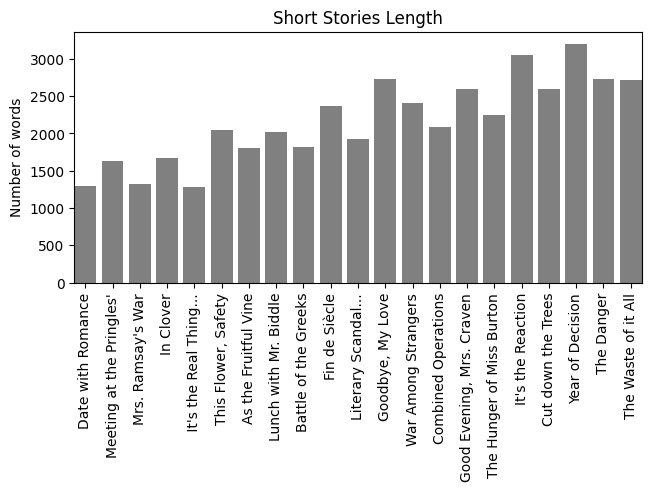

In [45]:
fig, ax = plt.subplots(constrained_layout=True)
ax.bar(titles_for_graphs, compound_table['number of words'], color='grey')
plt.xticks(rotation=90)
ax.margins(x=0)
plt.ylabel('Number of words')
plt.title('Short Stories Length')
plt.show()

Initially these short stories were written for *The New Yorker Magazine* which presupposed the format limitation as literary journals demand from their contributors (Harold Ross, magazine's editor, suggested her writing up to 1500 words, which in a paper edition was one spreadsheet with advertisment and illustrations). This considers that size of the short stories expected to be homogenous. The earliest pieces written at the first year of war and almost do not exceed 2000 words. However from the 9th-11th pices (*Battle of the Greeks*, 8 March 1941; *Fin de Siecle*, 12 July 1941; *Literary Scandal at the Sewing Party*, 6 September 1941), all for 1941 M. Panter-Downes tends to be more colloquious and wordy. As the correlation table also demonstrates with the length of the short stories the number of sentences as well as the lexicon richness (although in reals numbers it varies normally and remains around 500 words) of the short story. However, Panter-Downes does not mechanically corresponds her narrations with the number of paragraphs and their length in words, which demonstrates her rather unusual technique.
This is clear, that the initial size of a short story by the 1944 could not suffice her writing intentions, she needed more space to narrate the same typical plots.

### Words, Sentences & Paragraphs

From the extracted metrics the only constinent stylometric parameter is average word length which varies extremely insignificantly (CoV appr. 1%). In principle average word in *Good Evening, Mrs.Craven* is 5.5 characters which is slightly more than an average 5-charcter word in the Shakesperean corpus. The sentences which Panter-Downes composes for her fiction also are rather stable consisting of approximately 22.2 words. However, in a vicinity of of 10th-12th stories short stories cluster into two groups and some outliers. The pieces from *Mrs. Ramsay's War* up to *Battle of the Greek* are slightly sentecne longer that ones from *War Among Strangers*  to *The Waste of it All*. *Date with Romance*, *Meeting at the Pringles'* are minumum outliers in the first half of the stories colelction. *It's the Real Thing This Time* uses the longest sentecnes, however does not seem to be something extraordinary. From *Fin de Siecle*, in which Panter-Downes reaches the highest degree of her laconicity, excluding *Literary Scandal at the Sewing Party* in which she lengthens and sintactically sophisticates her and her characters phrases panter-Downes steadily recover the sentence length of 23-24 words. Second time, *Fin de Siecle* becomes a formal ridge for this collection of short stories.

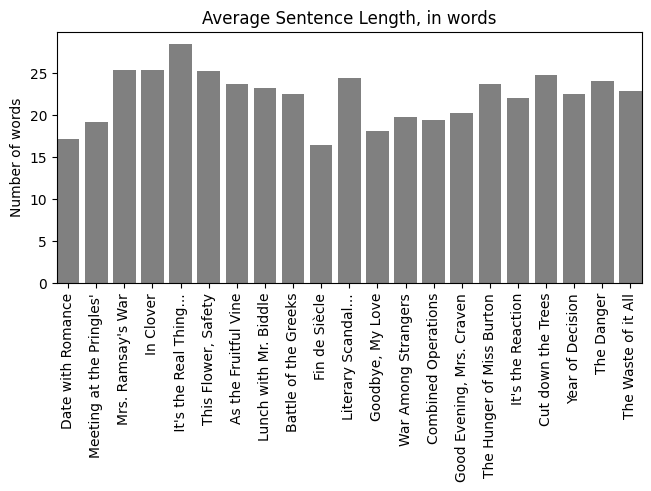

In [46]:
fig, ax = plt.subplots(constrained_layout=True)
ax.bar(titles_for_graphs, compound_table['average sentence length'], color='grey')
plt.xticks(rotation=90)
ax.margins(x=0)
plt.ylabel('Number of words')
plt.title('Average Sentence Length, in words')
plt.show()

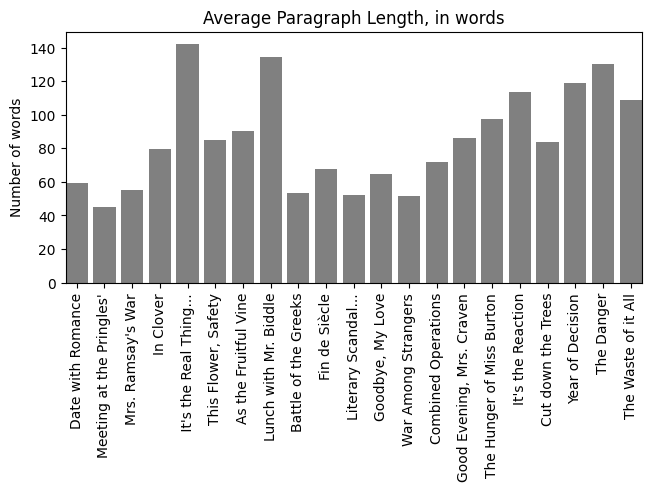

In [47]:
fig, ax = plt.subplots(constrained_layout=True)
ax.bar(titles_for_graphs, compound_table['average paragraph length in words'], color='grey')
plt.xticks(rotation=90)
ax.margins(x=0)
plt.ylabel('Number of words')
plt.title('Average Paragraph Length, in words')
plt.show()

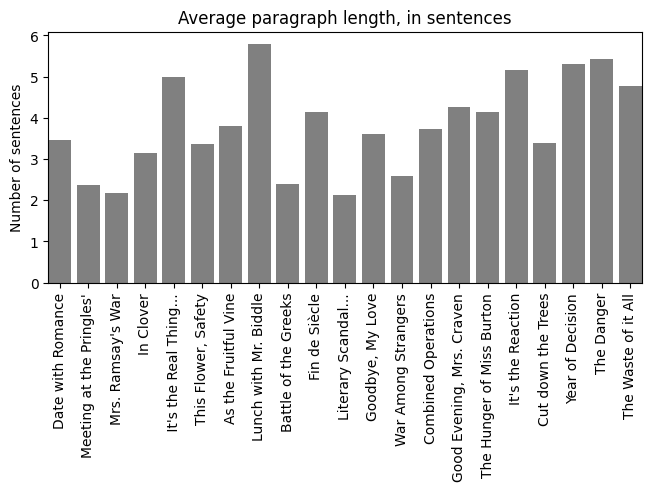

In [48]:
fig, ax = plt.subplots(constrained_layout=True)
ax.bar(titles_for_graphs, compound_table['average paragraph length in sentences'], color='grey')
plt.xticks(rotation=90)
ax.margins(x=0)
plt.ylabel('Number of sentences')
plt.title('Average paragraph length, in sentences')
plt.show()

However, paragraph length variations is explained by the ratio of dialogues (direct speech) in short stories. As dialogue lines significantly shorter that paragraphs of author's speech, the most "talkative" short stories have shorter paragraphs.

### Direct speech

From the scanned text we extracted the lines of direct speech. As the volume of texts is relatively unmassive and limited, we decided not to use regular expressions and implement direct speech extraction manually. For every short stories in the collection there is a file with lines of direct speech which is character's speech.

In [49]:
sh_st_direct_speech = [] # compile in one list all direct speech as strings
for title in range(1,22):
    with open(f'direct speech/{title}.txt') as f:
        text = f.read()
    sh_st_direct_speech.append(text)


In [50]:
new_compound_table = compound_table.copy()

In [51]:
direct_speech_w_length = [] # write in list the length of direct speech
for story in sh_st_direct_speech:
    text = TextAnalyzer(story)
    direct_speech_w_length.append(text.text_number_of_words())
table_with_d_speech = new_compound_table
table_with_d_speech['Length of direct speech'] = direct_speech_w_length
table_with_d_speech['Percentage of direct speech'] = table_with_d_speech['Length of direct speech'] / table_with_d_speech['number of words'] * 100

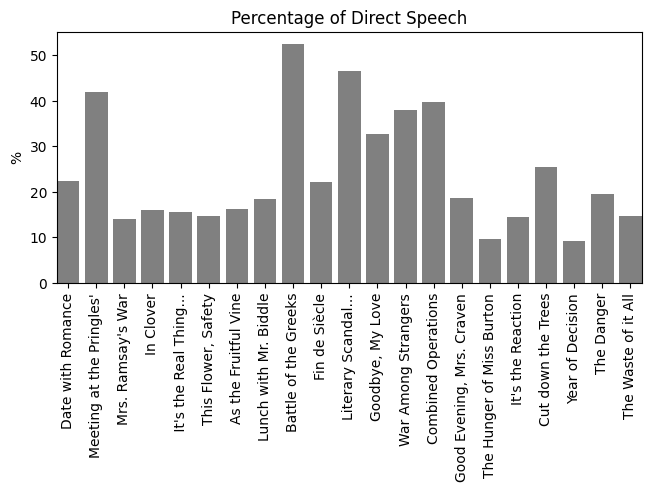

In [52]:
fig, ax = plt.subplots(constrained_layout=True);
ax.bar(titles_for_graphs, table_with_d_speech['Percentage of direct speech'], color='grey')
plt.xticks(rotation=90)
ax.margins(x=0)
plt.ylabel('%')
plt.title('Percentage of Direct Speech')
plt.show()

The highest share of direct speech, unsurprisingly, belongs to the "sewing party" trilogy which include also the highest number of major (with direct speech) characters. Among the "sewing party"

In [53]:
direct_speech_neg_sentiment = []
for story in sh_st_direct_speech:
    text = TextAnalyzer(story)
    sentiment = text.text_total_sentiment()
    direct_speech_neg_sentiment.append(sentiment['neg'])
table_with_d_speech['Negative sentiment of direct speech'] = direct_speech_neg_sentiment
table_with_d_speech

,number of words,number of sentences,number of unique words,number of paragraphs,average word length,average sentence length,average paragraph length in sentences,average paragraph length in words,sentiment negative,sentiment neutral,sentiment positive,sentiment compound,Length of direct speech,Percentage of direct speech,Negative sentiment of direct speech
title,,,,,,,,,,,,,,,
1. Date with Romance,1301,76,484,22,5.515757,17.118421,3.454545,59.136364,0.057,0.825,0.118,0.9978,291,22.367410,0.029
2. Meeting at the Pringles',1624,85,518,36,5.487685,19.105882,2.361111,45.111111,0.075,0.821,0.104,0.9956,679,41.810345,0.056
3. Mrs. Ramsay's War,1317,52,481,24,5.599089,25.326923,2.166667,54.875000,0.070,0.822,0.109,0.9937,183,13.895216,0.108
4. In Clover,1669,66,563,21,5.517076,25.287879,3.142857,79.476190,0.094,0.789,0.117,0.9939,265,15.877771,0.044
5. It's the Real Thing This Time,1281,45,517,9,5.442623,28.466667,5.000000,142.333333,0.100,0.790,0.110,0.9534,198,15.456674,0.146
"6. This Flower, Safety",2043,81,714,24,5.641214,25.222222,3.375000,85.125000,0.085,0.818,0.097,0.9865,297,14.537445,0.037
7. As the Fruitful Vine,1802,76,624,20,5.502775,23.710526,3.800000,90.100000,0.087,0.765,0.148,0.9988,291,16.148724,0.068
8. Lunch with Mr. Biddle,2015,87,720,15,5.711166,23.160920,5.800000,134.333333,0.087,0.747,0.166,0.9996,370,18.362283,0.071
9. Battle of the Greeks,1817,81,590,34,5.588332,22.432099,2.382353,53.441176,0.099,0.772,0.128,0.9957,954,52.504128,0.114


In [54]:
table_with_d_speech.describe()

,number of words,number of sentences,number of unique words,number of paragraphs,average word length,average sentence length,average paragraph length in sentences,average paragraph length in words,sentiment negative,sentiment neutral,sentiment positive,sentiment compound,Length of direct speech,Percentage of direct speech,Negative sentiment of direct speech
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,2167.857143,99.857143,685.047619,27.571429,5.495800,22.257823,3.813946,85.236574,0.083143,0.802905,0.114000,0.977352,504.047619,23.836526,0.070667
std,567.212419,30.926179,127.657149,8.925085,0.106855,3.100920,1.127621,29.758752,0.012285,0.025513,0.019445,0.050705,263.012638,12.734730,0.032475
min,1281.000000,45.000000,481.000000,9.000000,5.292824,16.337931,2.135135,45.111111,0.057000,0.747000,0.086000,0.810000,183.000000,9.017161,0.016000
25%,1802.000000,79.000000,590.000000,22.000000,5.440556,19.770492,3.142857,59.136364,0.075000,0.789000,0.099000,0.993700,291.000000,14.675516,0.056000
50%,2086.000000,95.000000,695.000000,27.000000,5.487685,22.789916,3.724138,83.806452,0.082000,0.811000,0.109000,0.997500,438.000000,18.557099,0.071000
75%,2598.000000,122.000000,774.000000,34.000000,5.565727,24.341772,4.760000,108.480000,0.091000,0.822000,0.122000,0.998700,679.000000,32.551320,0.081000
max,3205.000000,151.000000,906.000000,47.000000,5.711166,28.466667,5.800000,142.333333,0.104000,0.837000,0.166000,0.999600,954.000000,52.504128,0.146000


### Characters 

Panter-Downes short stories are oversaturated with characters, both main (speaking) and secondary (only mentioned in text). The list of that characters were compiled manualy (without using Named Entity Recognition which can identify places' names and people's names automatically, as the set of text was rather small). Also all characters were marked as men, women, children, or men and women of it was named as family couple, but the number of this entries insignificant.


In [55]:
lines = []
main_characters = []
secondary_characters = []
number_of_characters = []
female_characters = []
male_characters = []
female_main = []
male_main = []
female_secondary = []
male_secondary = []
children_characters = []
MF_characters = []
characters = []

with open ("/home/felix/Documents/my python projects/Mollie-Panter-Downes-wartime-short-stories/characters' names.txt") as f:
    lines = f.read()
lines = lines.split('\n')
for line in lines:
    female_characters.append(line.count("(F)"))
    male_characters.append(line.count("(M)"))
    children_characters.append(line.count('(CH)'))
    MF_characters.append(line.count('(MF)'))
    subline = line.split(': ')
    characters.append(subline[1])
    line_characters = subline[1].split('; ')
    line_main_characters = line_characters[0]
    line_sec_characters = line_characters[1]
    female_main.append(line_main_characters.count("(F)"))
    male_main.append(line_main_characters.count('(M)'))
    main_characters.append(line_main_characters.split(', '))
    secondary_characters.append(line_sec_characters.split(', '))
    female_secondary.append(line_sec_characters.count('(F)'))
    male_secondary.append(line_sec_characters.count('(M)'))

Main characters

In [56]:
main_characters

[['(F) Helen Ramsay', '(M) Mr. Gerald Spalding'],
 ['(F) Ms. Lois Pringle',
  '(F) Ms. Alice Pringle',
  '(F) Mrs. Taylor',
  '(F) Mrs. Peake',
  '(F) Ms. Lois Craddock',
  '(F) Mrs. Doris Carver'],
 ['(F) Mrs. Ramsay', '(F) Mrs. Susan Ramsay', ' (F) Mrs. Parmenter'],
 ['(F) Miss Vereker',
  '(F) Mrs. Clark',
  '(F) Mrs. Fletcher',
  '(F) Mrs. Clark',
  '(M) Captain Fletcher',
  '(M) Mr. Clark'],
 ['(M) Major Gerald Marriot', '(F) Miss Marriot', '(F) Mrs. Trent'],
 ['(F) Miss Mildred Ewing',
  '(F) Sparks',
  '(F) Mrs. Prentiss',
  '(F) Miss Challoner',
  "(M) Miss Ewing's nephew"],
 ['(F) Lucy Grant',
  '(M) Philip Grant',
  "(F) Lucy's mother",
  '(F) Valerie',
  '(M) Bernard',
  '(F) Monica',
  '(M) The bus conductor'],
 ['(M) Winthrop Biddle',
  '(F) Mme. Delacroix',
  '(F) Mrs. Maverick',
  '(F) Effie Trumpington',
  '(F) Dora Cunningham',
  '(M) General Sysonby',
  '(F) Ursula Farmer',
  '(F) Mrs. Sysonby',
  '(M) Mr. Potts',
  '(M) Carter',
  '(M) Gardener'],
 ['(F) Mrs. Ramsay'

Table of Characters

In [57]:
characters_table = pd.DataFrame()
characters_table['titles'] = ordered_titles
characters_table['number of main characters'] = [len(item) for item in main_characters]
characters_table['among them women'] = female_main
characters_table['number of mentioned characters'] = [len(item) for item in secondary_characters]
characters_table['...among them women'] = female_secondary
characters_table['...among them men'] = male_secondary
characters_table['all characters'] = characters_table['number of main characters'] + characters_table['number of mentioned characters']
characters_table['number of female characters'] = female_characters
characters_table['number of male characters'] = male_characters
characters_table

,titles,number of main characters,among them women,number of mentioned characters,...among them women,...among them men,all characters,number of female characters,number of male characters
0,1. Date with Romance.txt,2,1,4,3,1,6,4,2
1,2. Meeting at the Pringles'.txt,6,6,5,3,1,11,9,1
2,3. Mrs. Ramsay's War.txt,3,3,6,2,4,9,5,4
3,4. In Clover.txt,6,4,4,1,2,10,5,4
4,5. It's the Real Thing This Time.txt,3,2,1,1,0,4,3,1
5,"6. This Flower, Safety.txt",5,4,2,1,1,7,5,2
6,7. As the Fruitful Vine.txt,7,4,4,1,2,11,5,5
7,8. Lunch with Mr. Biddle.txt,11,6,6,3,1,17,9,6
8,9. Battle of the Greeks.txt,8,7,3,0,3,11,7,4
9,10. Fin de Siecle.txt,4,1,11,3,7,15,4,10


Number of main characters

In [58]:
characters_table['number of main characters'].sum()

107

Number of secondary characters

In [59]:
characters_table['number of mentioned characters'].sum()

90

For 21 short stories this amount is rather significant, making them more like a chorus or a hive.

In [60]:
characters_table.describe()

,number of main characters,among them women,number of mentioned characters,...among them women,...among them men,all characters,number of female characters,number of male characters
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,5.095238,3.428571,4.285714,1.428571,1.952381,9.380952,4.857143,3.380952
std,2.165751,1.938335,2.512824,1.028175,1.935877,3.528118,2.056349,2.268836
min,2.000000,1.000000,1.000000,0.000000,0.000000,4.000000,2.000000,1.000000
25%,4.000000,2.000000,3.000000,1.000000,1.000000,6.000000,3.000000,2.000000
50%,5.000000,3.000000,4.000000,1.000000,1.000000,10.000000,5.000000,2.000000
75%,6.000000,4.000000,5.000000,2.000000,3.000000,11.000000,5.000000,4.000000
max,11.000000,8.000000,11.000000,3.000000,7.000000,17.000000,9.000000,10.000000


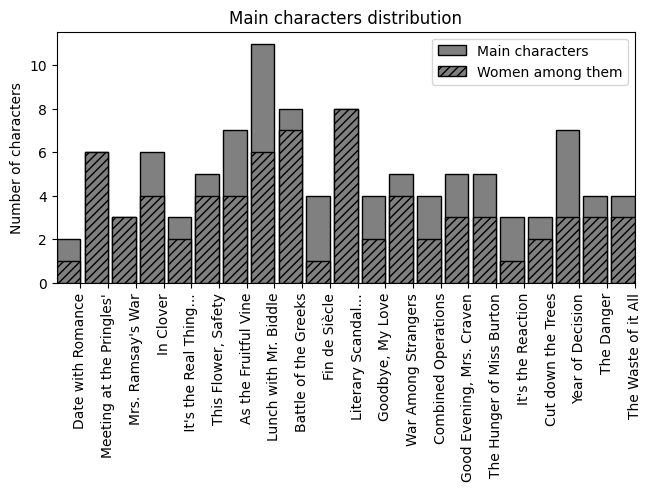

In [61]:
fig, ax = plt.subplots(constrained_layout=True)
# Set the width of the bars
bar_width = 0.85
# Define colors for the bars
colors = ['#069AF3', 'gray']

# Create an array of x values for the bars
x = np.arange(len(titles_for_graphs))
# Plot the bars for 'number of main characters'
rects1 = ax.bar(
    x - bar_width/2,
    characters_table['number of main characters'],
    width=bar_width,
    color='grey',
    label='Main characters',
    edgecolor='black'
)
# Plot the bars for 'among them women' with hatch patterns
rects2 = ax.bar(
    x - bar_width/2,
    characters_table['among them women'],
    width=bar_width,
    color='grey',
    edgecolor='black',
    hatch='////',
    label='Women among them'
)
# Customize the plot
ax.set_ylabel('Number of characters')
ax.set_title('Main characters distribution')
ax.set_xticks(x)
ax.set_xticklabels(titles_for_graphs)
ax.legend()

# Show the plot
plt.xticks(rotation=90)
plt.margins(x=0)
plt.show()
#4c33ff


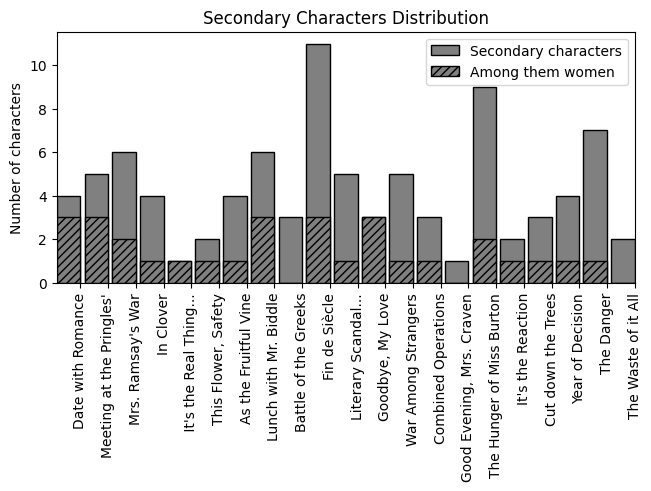

In [62]:
fig, ax = plt.subplots(constrained_layout=True)
bar_width = 0.85
colors = ['#069AF3', 'grey']
x = np.arange(len(titles_for_graphs))

rects1 = ax.bar(
    x - bar_width/2,
    characters_table['number of mentioned characters'],
    width=bar_width,
    color='grey',
    edgecolor = 'black',
    label='Secondary characters'
)

rects2 = ax.bar(
    x - bar_width/2,
    characters_table['...among them women'],
    width=bar_width,
    color='grey',
    edgecolor='black',
    hatch='////',
    label='Among them women'
)
ax.set_ylabel('Number of characters')
ax.set_title('Secondary Characters Distribution')
ax.set_xticks(x)
ax.set_xticklabels(titles_for_graphs)
ax.legend()

plt.xticks(rotation=90)
plt.margins(x=0)
plt.show()

Even without statical overview, just reading the short stories we mention that women are the major actors of Panter-Downes' short stories. The more peculiar fact is that male characters were "exciled" into a backstage, having occupied the secondary role.

### Sentiment of short stories

Sentiment analysis (SA) is rarely used in literary studies as its adequacy of measuring sentiment, score of emotions, which a text produces, arises questions, which was mentioned in the article. The sentiment analysis was not designed for literary studies but for more practical purposes as identification if the review on a website is positive or negative. Jockers used SA as a tool to analyze the plot change in *Moby-Dick*, and some authors, mentioned in the article, profoundly showed limitations and almost uselessness of SA for literary works. I argue that it can benefit. First, I preconsider text of one author homogenous and the distribution of cases in which SA model makes mistakes normal. That means that the distribution of mistakes in the text wil be homogenous and will not spoil the results. Secondly, I do not consider that this sentiment reflects the real emotion this text arises. If, in general, we can with ease state if that or so sentence contains more positive or negative, even may compare it and say that this sentence is softer in reflexing negative emotions than other ones, stating that the mood, emotion, "meaning" is ambivalent and cannot be characterized in dichotomic statement. I can characterize the line of dialogue, maybe all the lines of one characters but in many situations I cannot even say if the characters show positive attitude and is it same positive as the attitude of author's speech. Even if SA mistakes in particular cases, I can trust it comparing rather large parts of the text between one another.

VADER sentiment, chosen by me, seems ti be the most suitable. In Kim's tests it demonstrates rather goods results, as have rather developed mechanism of sentiment estimation which includes not only vocabulary estimation but "switchers which can diametrically change the sentiment and cases which intensify or soften sentiment of the sentence.

My hypothesis was that Panter-Downes protects her characters by war effect, taking on herself the burden to express negative emotions from the shoulders of her characters. The sufficient case is that negative sentiment of text in average will be in absolute value higher than the negative sentiment of characters speech, i.e. characters will be less negative than the text in average.


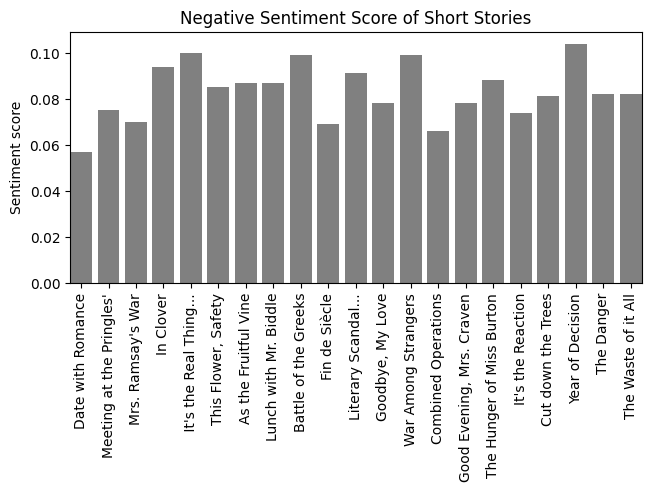

In [63]:
fig, ax = plt.subplots(constrained_layout=True)
ax.bar(titles_for_graphs, compound_table['sentiment negative'], color='grey')
plt.xticks(rotation=90)
ax.margins(x=0)
plt.ylabel('Sentiment score')
plt.title('Negative Sentiment Score of Short Stories')
plt.show()

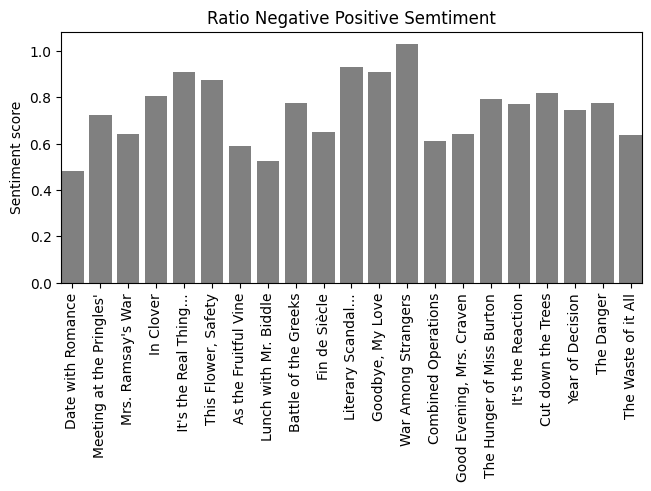

In [64]:
fig, ax = plt.subplots(constrained_layout=True)
ax.bar(titles_for_graphs, compound_table['sentiment negative'] / compound_table['sentiment positive'], color='grey')
plt.xticks(rotation=90)
ax.margins(x=0)
plt.ylabel('Sentiment score')
plt.title('Ratio Negative Positive Semtiment')
plt.show()

Nevertheless, the length of Panter-Downes' sentences surprisingly correlates with negative sentiment score (cor = 0.56). Why when tonality towards war become more negative Panter-Downes' sentences lengthen? Whose sentences, of the author or her characters?\
In all short stories except for #13 *War among the Strangers* averall sentiment of the pieces is positive. And the fluctiations of negative sentiment (it is more picteresque if we look at negative-positive sentiment ratio), which is more important in defining the move of tonality for war literature, show that in the collection there are three flows of intensifying negative sentiment from 1 to 5, decline from 6 to 8, again growth from 9 to 13, abrupt fall and the initiation of the final wave of weak platauing sentiment intensification from 14 to 21, which suggests for criticism another approach to clustering short stories in the collection.
However, by the end of war, as the length of Panter-Downes short story was increasing, the more gloomy they were becoming, which is also evident without using specific tools

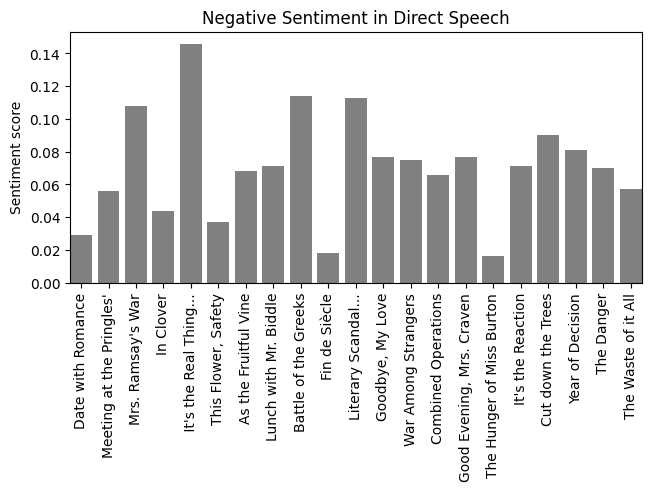

In [65]:
fig, ax = plt.subplots(constrained_layout=True);
ax.bar(titles_for_graphs, table_with_d_speech['Negative sentiment of direct speech'], color='grey')
plt.xticks(rotation=90)
ax.margins(x=0)
plt.ylabel('Sentiment score')
plt.title('Negative Sentiment in Direct Speech')
plt.show()

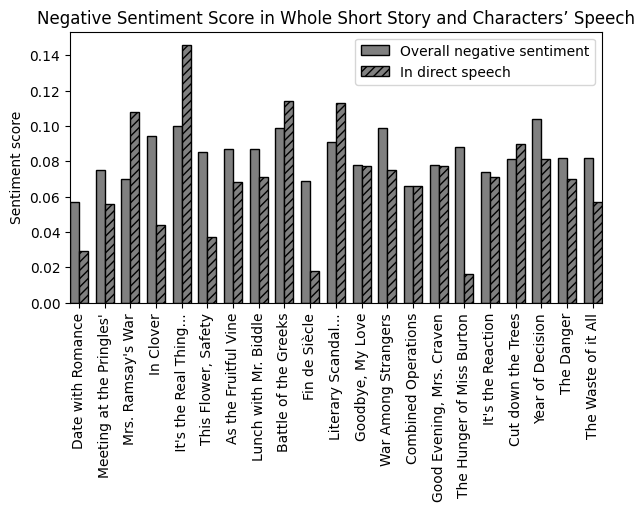

In [97]:
# Create a figure and axis
fig, ax = plt.subplots(constrained_layout=True, figsize=(6,5))

# Set the width of the bars
bar_width = 0.35

# Define colors for the bars
colors = ['#069AF3', 'gray']

# Create an array of x values for the bars
x = np.arange(len(titles_for_graphs))

# Plot the bars for 'sentiment negative'
rects1 = ax.bar(
    x - bar_width / 2,
    compound_table['sentiment negative'],
    width=bar_width,
    color='grey',
    edgecolor='black',
    label='Overall negative sentiment'
)

# Calculate the x-coordinates for the bars for 'Negative sentiment of direct speech'
x2 = [xi + bar_width / 2 for xi in x]
rects2 = ax.bar(
    x2,
    table_with_d_speech['Negative sentiment of direct speech'],
    width=bar_width,
    color='grey',
    edgecolor='black',
    hatch='////',
    label='In direct speech'
)

# Customize the plot
ax.set_ylabel("Sentiment score")
ax.set_title("Negative Sentiment Score in Whole Short Story and Characters’ Speech")
ax.set_xticks(x)
ax.set_xticklabels(titles_for_graphs)
ax.legend()

# Show the plot
plt.xticks(rotation=90)
plt.margins(x=0)
plt.savefig("figure 6.png", dpi=300)
plt.show()

The final of many short stories is opened and a reader may onlu hope and imagine individually what will at the very end. Certainly, mostly becuase of Panter-Downes' life assuaring journalism, her image of a proud Briton, we extrapolate this on her short stories, considering that they should raise the morale of American readers and show that Britain is still alive and people here live their small life, not falling into despair. I decided to look at the tendency of sentiment to be assured in this. I measured the compound sentiment (it is the summation of negative and postive sentiment, showing overall score and emotion of the sentence) for every sentence of each text.

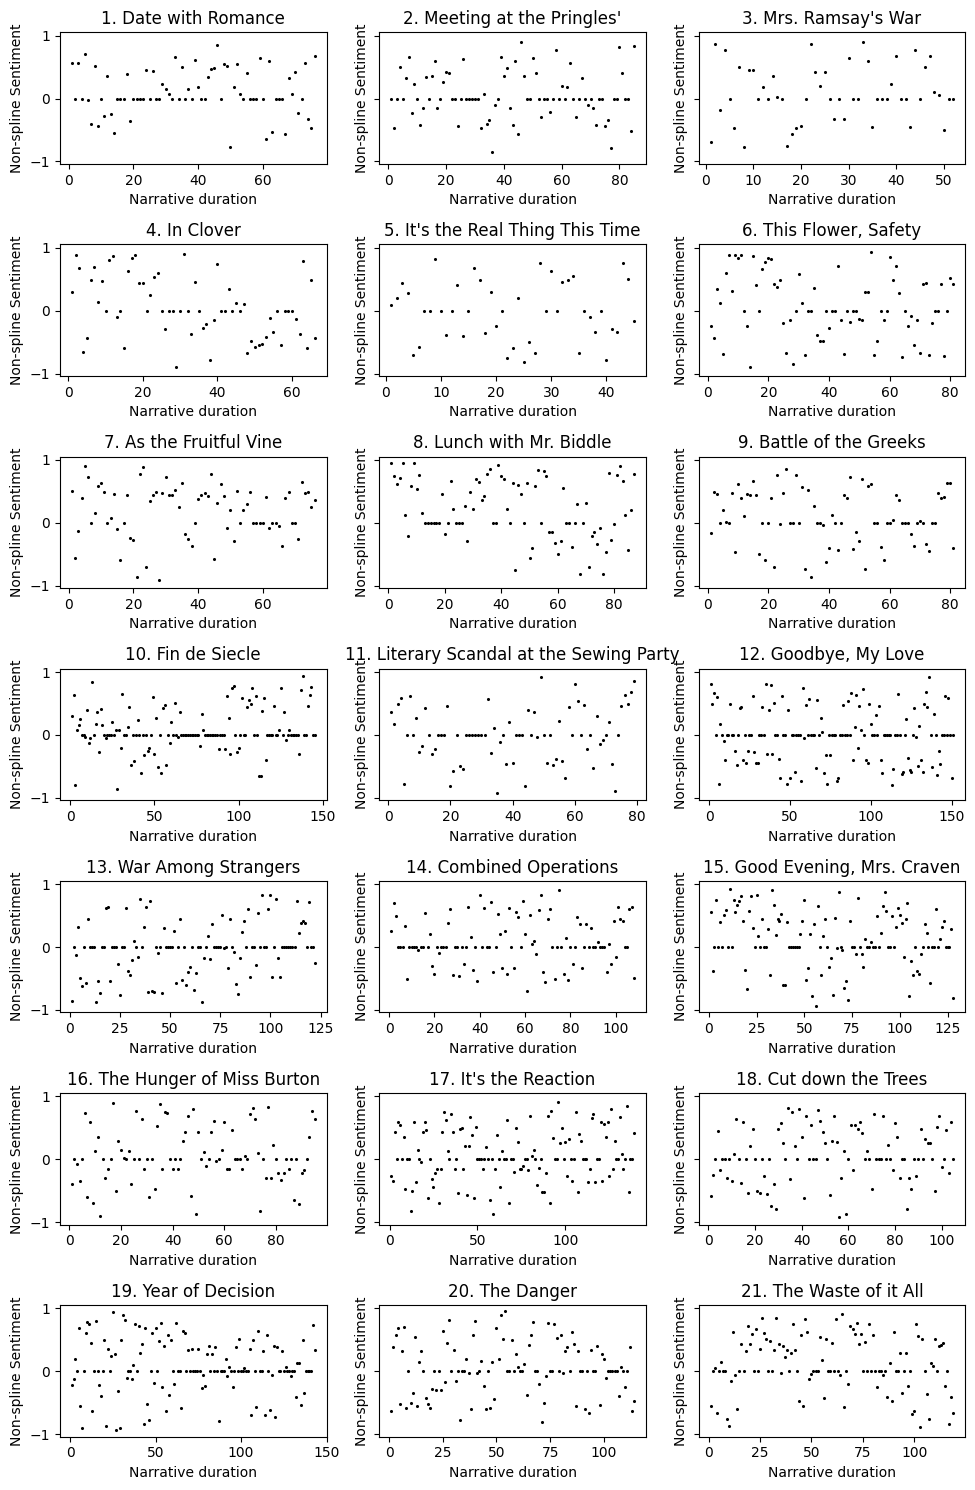

In [67]:
ig, axes = plt.subplots(nrows=7, ncols=3, figsize=(10, 15), sharey=True)  # figsize is adjusted for visibility
counter = 0
for row in axes:
    for ax in row:
        story = TextAnalyzer(all_texts_as_str[counter][:-4])
        data = story.text_rawsentiplot()
        ax.scatter(data[1], data[0], marker='.', s=6, color="black")
        ax.set_title(f'{ordered_titles[counter][:-4]}')
        ax.set_xlabel('Narrative duration')
        ax.set_ylabel('Non-spline Sentiment')
        counter += 1
    counter = counter
    

plt.tight_layout()
#plt.savefig('Sentiments.png')
plt.show()

However, this data is too disperded to show a general tendency. To "smoothen" the data, I used spline method.

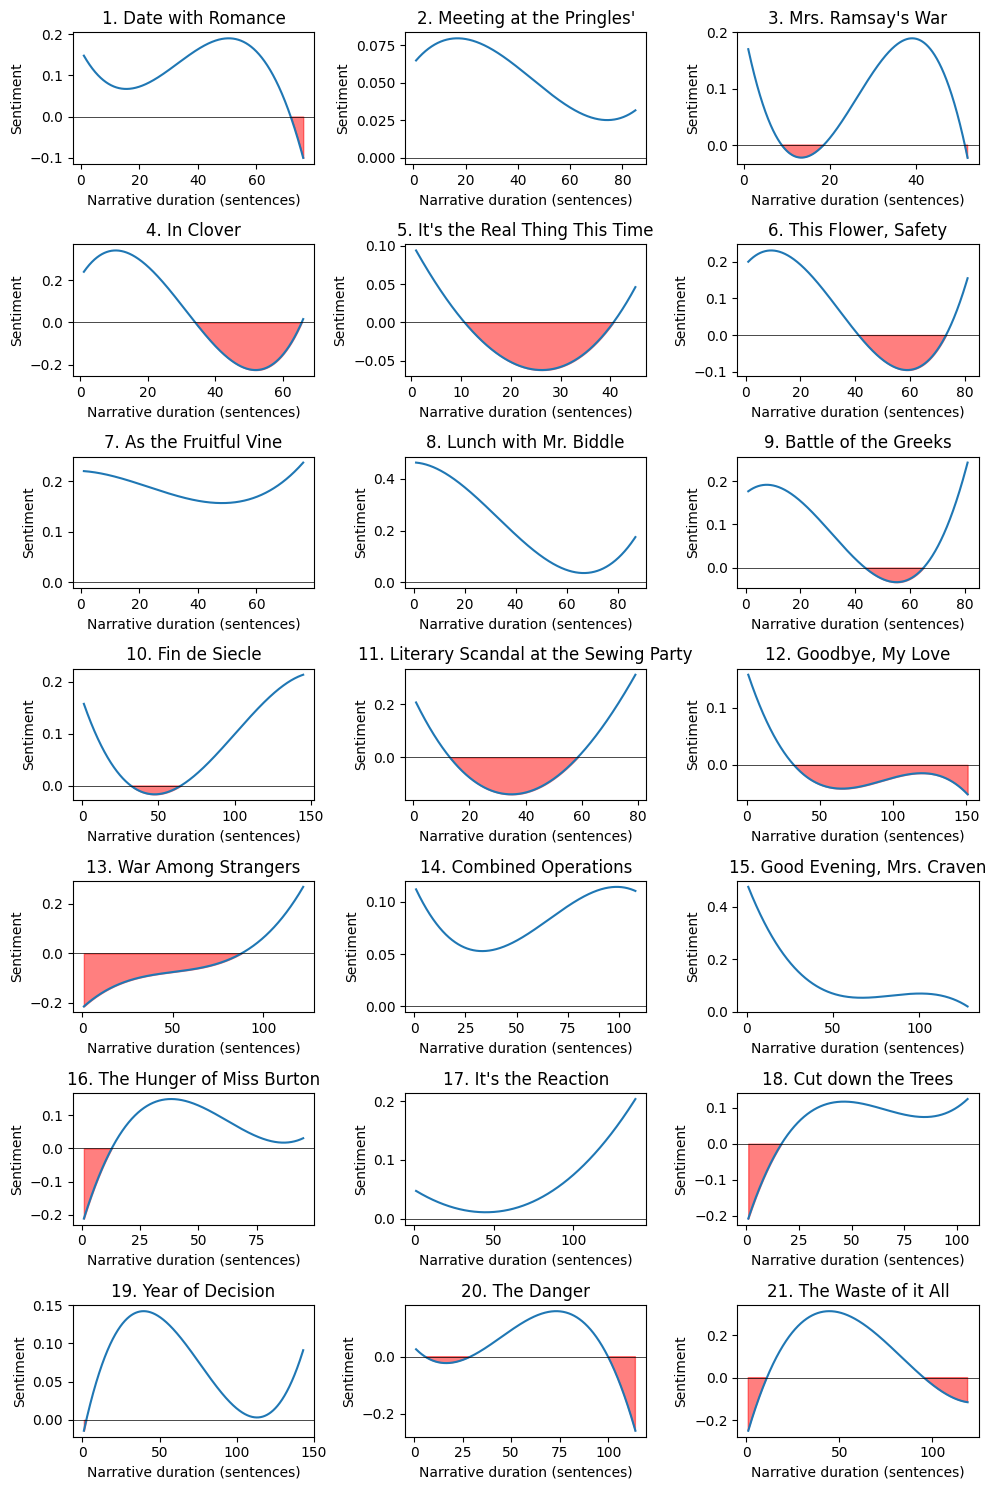

In [68]:
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(10, 15))  # figsize is adjusted for visibility
counter = 0
for row in axes:
    for ax in row:
        story = TextAnalyzer(all_texts_as_str[counter][:-4])
        data = story.text_sentiplot(30)
        ax.plot(data[0], data[1])
        ax.fill_between(data[0], data[1], where=(data[1] < 0), interpolate=True, color='red', alpha=0.5)
        ax.axhline(0, color='black', linewidth=0.5)
        ax.set_title(f'{ordered_titles[counter][:-4]}')
        ax.set_xlabel('Narrative duration (sentences)')
        ax.set_ylabel('Sentiment')
        counter += 1
    counter = counter
    

plt.tight_layout()
plt.savefig('Sentiments.png')
plt.show()

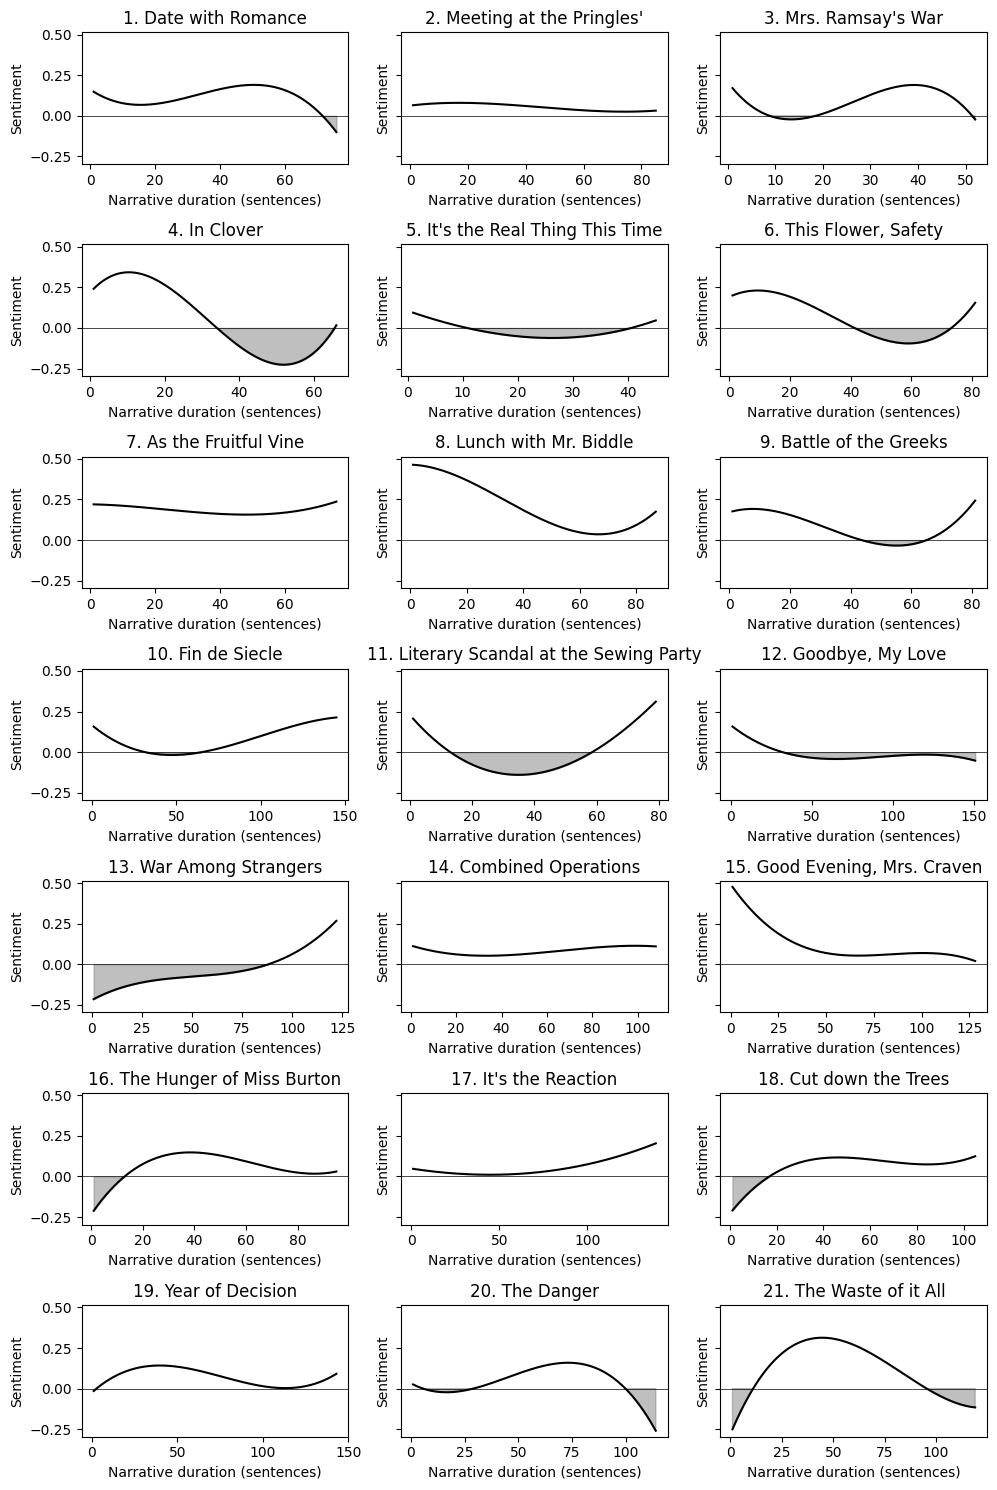

In [69]:
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(10, 15), sharey=True)  # figsize is adjusted for visibility
counter = 0
for row in axes:
    for ax in row:
        story = TextAnalyzer(all_texts_as_str[counter][:-4])
        data = story.text_sentiplot(30)
        ax.plot(data[0], data[1], color='black')
        ax.fill_between(data[0], data[1], where=(data[1] < 0), interpolate=True, color='grey', alpha=0.5)
        ax.axhline(0, color='black', linewidth=0.5)
        ax.set_title(f'{ordered_titles[counter][:-4]}')
        ax.set_xlabel('Narrative duration (sentences)')
        ax.set_ylabel('Sentiment')
        counter += 1
    counter = counter
    

plt.tight_layout()
plt.savefig('Sentiments.png')
plt.show()

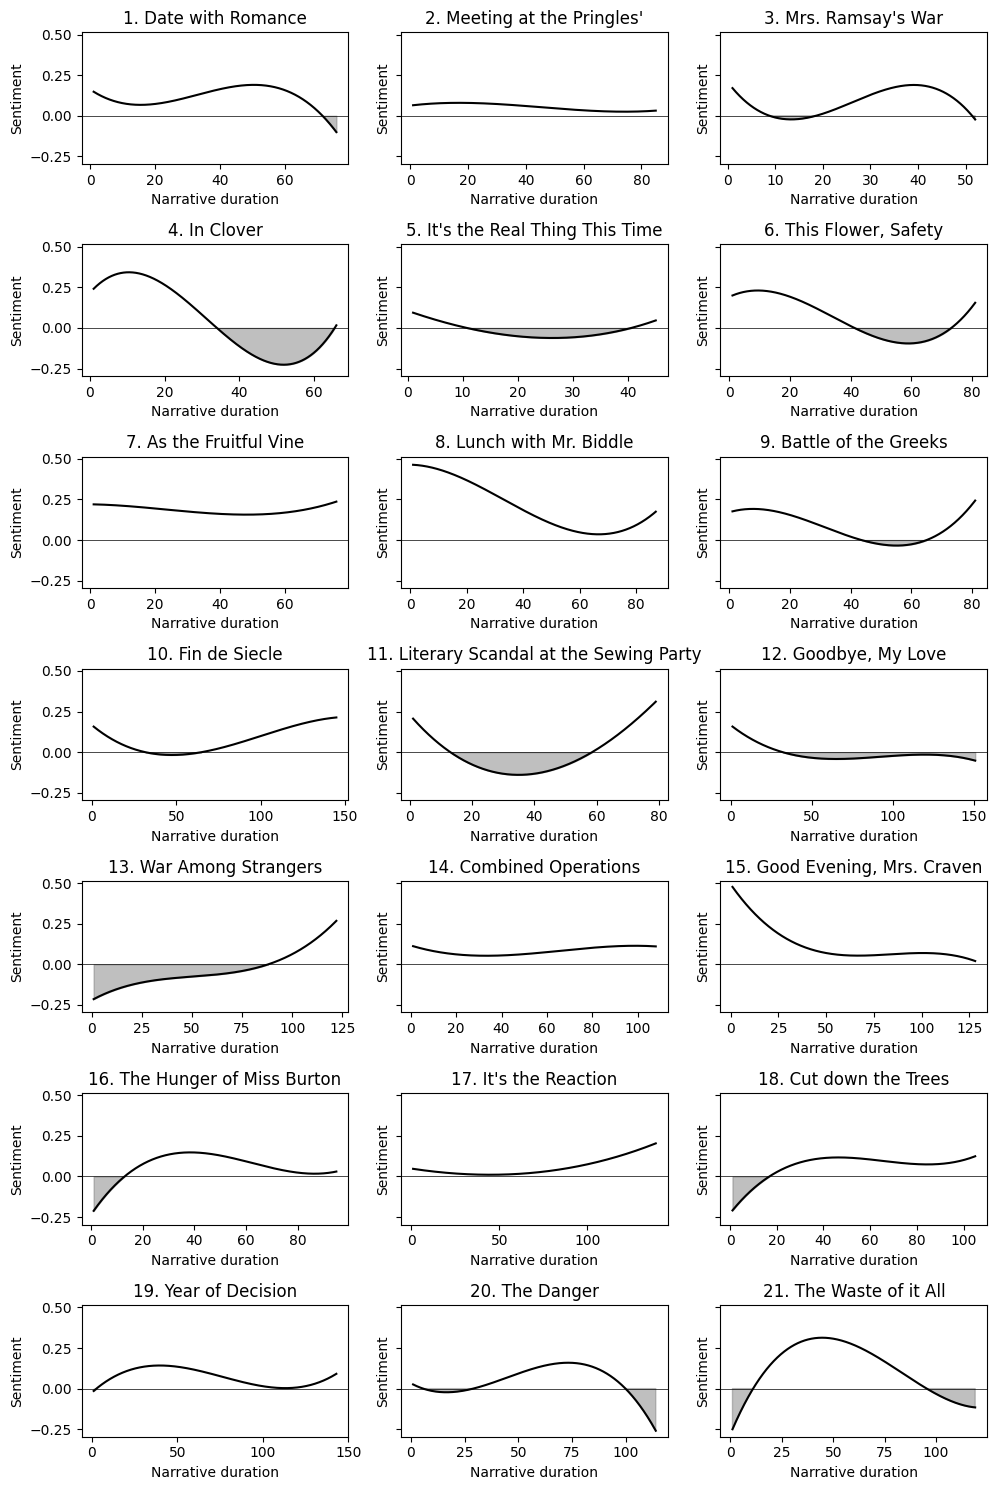

In [102]:
fig, axes = plt.subplots(nrows=7, ncols=3, sharey=True, figsize=(10, 15))  # figsize is adjusted for visibility
counter = 0

for row in axes:
    for ax in row:
        story = TextAnalyzer(all_texts_as_str[counter][:-4])
        data = story.text_sentiplot(30)
        
        x_values = data[0]
        y_values = data[1]
        
        ax.plot(data[0], data[1], color='black')
        
        # Fill areas below zero for each subplot
        ax.fill_between(data[0], data[1], where=(data[1] < 0), interpolate=True, color='grey', alpha=0.5)
        
        ax.axhline(0, color='black', linewidth=0.5)  # Optional: add a horizontal line at y=0 for reference
        ax.set_title(f'{ordered_titles[counter][:-4]}')
        ax.set_xlabel('Narrative duration')
        ax.set_ylabel('Sentiment')
        
        counter += 1

plt.tight_layout()
plt.savefig('figure 7.png', dpi=300)
plt.show()

Several patterns of curves may be identified, but we cannot trust them as a lines, indicating any plot movement, but it is visible, that the majority of her short stories finish in high note, but at the second period of war she was not so optimistic. Maybe, that is the reason why she stopped publishing short stories in 1944 as it was impossible to protect her imaginary world from war causalities.

### Some other approaches which have not shawn results


### Semantic domain of war

The key feature of ant war literature is the way how war is reflected, comprehended and imaged in texts of this genre. Semantic domain of war concept may characterize the way Panter-Downes represented the war, built its image on the pages of her short stories. Formally, semantic domain is a "is an area of meaning and the words used to talk about it. A domain is often given a name consisting of a common word in the domain. For instance English has a domain ‘Rain’, which includes words such as rain, drizzle, downpour, raindrop, puddle. We use these words to talk about the rain" [3]. So, semantic domains contains its core word and its associates. Thus, semantic domain of war presents as here:\
**"What words refer to war?**\
war, warfare, fighting, civil war, conflict, armed conflict,\
**What words refer to fighting a war?**\
fight a war, wage war, be at war, declare war, make war, go on the warpath, fight, clash,\
**What words refer to a time when armies fight?**\
war, battle, campaign, engagement, fight, contest, clash, skirmish\
**What words refer to the place where a war is fought?**\
battlefield, field of battle, theater of war, scene of the battle, front, front lines, flank, rear, war zone,\
**What words refer to strategy in war?**\
strategy, tactics, hunker down, keep up the pressure, overwhelm, concentrate your forces, form a line, hold the line, break the line, reform, rally, morale, maintain morale, military discipline, supply, supply lines, control the battle, battlefield control, reconnaissance, reconnoiter, intelligence, propaganda,\
**What words refer to an army moving?**\
deploy, maneuver, outmaneuver, flank, outflank, advance, charge, overrun, retreat, withdraw\
**What words refer to a person who fights on your side?**\
ally\
**What words refer to a person who wants to fight a war?**\
warmonger, militarist, hawk,\
**What words describe a person or country that wants to fight a war?**\
warlike,\
**What words describe countries that are at war?**\
warring\
**What words refer to someone who is hurt or killed in a war?**\
casualty, missing in action,"\
\
The compilations of these associated words was done via serveys of respondents who were asked which assosiations they have with war. And these assosiations may be used in our analysis as any reference to common truth while it heuristically does not make any distortions.\
The first way to solidly estimate the presense and intensity of war presense in text is to count war assosiates from the ready sematic domain.

In [71]:
search_results = []
results_for_table = []

for title in tqdm(ordered_titles):
    with open(f'Good Evening, Mrs. Craven texts/{title}', encoding='utf-8') as f:
        short_story = f.read()
        text = TextAnalyzer(short_story)
        lemmatized_text = text.text_lemmatization()
        results = war_semantic_field(lemmatized_text)
        search_results.append(results)
        summ_of_indents = [sum(line) for line in results[0]]
        results_for_table.append(sum(summ_of_indents))

new_compound_table = compound_table.copy()        
new_compound_table ['Semantic Domain (number of war related associates)'] = results_for_table

/home/felix/miniconda3/envs/mollie/lib/python3.12/site-packages/tqdm/std.py:465: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  if rate and total else datetime.utcfromtimestamp(0))
100%|██████████| 21/21 [00:04<00:00,  4.95it/s]


In [72]:
list_of_found_concordances = [line[1] for line in search_results]
list_of_found_concordances

[[['war', 'war'],
  ['front', 'front'],
  ['rally'],
  ['ally', 'ally', 'ally', 'ally', 'ally']],
 [['war', 'war', 'war', 'war', 'war', 'war'],
  ['front', 'front'],
  ['supply', 'supply', 'supply'],
  ['charge', 'charge'],
  ['ally', 'ally']],
 [['war', 'war', 'war', 'war', 'war', 'war', 'war'],
  ['battle'],
  ['charge'],
  ['retreat'],
  ['ally', 'ally', 'ally']],
 [['war', 'war', 'war', 'war', 'war', 'war'],
  ['charge'],
  ['ally', 'ally', 'ally', 'ally']],
 [['war', 'war', 'war', 'war', 'war', 'war', 'war', 'war', 'war', 'war'],
  ['fighting'],
  ['fight'],
  ['fight'],
  ['front'],
  ['flank'],
  ['flank'],
  ['ally', 'ally'],
  ['casualty']],
 [['war',
   'war',
   'war',
   'war',
   'war',
   'war',
   'war',
   'war',
   'war',
   'war',
   'war'],
  ['front', 'front'],
  ['charge'],
  ['ally', 'ally', 'ally']],
 [['war', 'war', 'war', 'war', 'war'],
  ['engagement'],
  ['front', 'front'],
  ['rally'],
  ['ally', 'ally', 'ally', 'ally', 'ally']],
 [['war', 'war', 'war', 'war

The most frequent words of this domain are "war" and "ally".

In [73]:
new_compound_table['Semantic Domain (number of war related associates)'].describe()

count    21.000000
mean     17.666667
std       6.605553
min       5.000000
25%      14.000000
50%      17.000000
75%      21.000000
max      36.000000
Name: Semantic Domain (number of war related associates), dtype: float64

In average, every short story comtains 17.7 items from the defined semantic domain of war. However, the stories demonstrated the significant variance in their formal volume parametres (length in words, sentences, paragraphs) which considers that absolute numbers do not adequately reflect the intensity of war-related semantic domain. Also, the most frequent common words (like articles, frequent pronouns, etc), which are in the heart of classic stylometry, do not carry speciffic significance in adding speciffic lexical meaning to the themes of the texts, i.e. to semantic domains. This distant reading analysis is insensible to minor connations (like how often the author avoids talking about war and its causalities, replacing such words with pronounce, i.e. making such lexis a kind of taboo). As the analysis considers such stop words as irrelevant, we count the percentage of war related semantic domain intensity by finding the ratio between the number of such entries of the domain and the number of unique words in text minus stop words.\
The percentage (intensity) of war semantic domain is following:

In [74]:
line_with_percentage_of_semantic_domain = new_compound_table['Semantic Domain (number of war related associates)'] / new_compound_table['number of unique words'] * 100
line_with_percentage_of_semantic_domain

title
1. Date with Romance                        2.066116
2. Meeting at the Pringles'                 2.895753
3. Mrs. Ramsay's War                        2.702703
4. In Clover                                1.953819
5. It's the Real Thing This Time            3.675048
6. This Flower, Safety                      2.380952
7. As the Fruitful Vine                     2.243590
8. Lunch with Mr. Biddle                    3.611111
9. Battle of the Greeks                     3.220339
10. Fin de Siecle                           2.109705
11. Literary Scandal at the Sewing Party    1.954887
12. Goodbye, My Love                        1.915709
13. War Among Strangers                     3.382353
14. Combined Operations                     0.763359
15. Good Evening, Mrs. Craven               2.589928
16. The Hunger of Miss Burton               3.006536
17. It's the Reaction                       2.607710
18. Cut down the Trees                      1.765448
19. Year of Decision                    

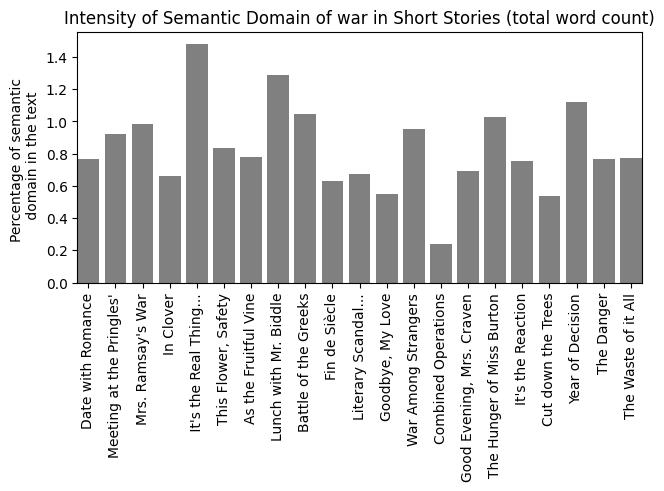

In [75]:
fig, ax = plt.subplots(constrained_layout=True)
ax.bar(titles_for_graphs, new_compound_table['Semantic Domain (number of war related associates)'] / new_compound_table['number of words'] * 100,
       color='grey')
plt.xticks(rotation=90)
ax.margins(x=0)
plt.ylabel('Percentage of semantic \n domain in the text')
plt.title('Intensity of Semantic Domain of war in Short Stories (total word count)')
plt.show()

### Topic Modeling
Latent Dirichlet Allocation (LDA)

In [76]:
texts = []
lemmatized_texts = []
for title in tqdm(ordered_titles):
    with open(f'Good Evening, Mrs. Craven texts/{title}', encoding='utf-8') as f:
        short_story = f.read()
    text = TextAnalyzer(short_story)
    lemmatized = text.text_lemmatization()
    lemmatized_texts.append(lemmatized)
    texts.append(lemmatized)

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=100)

topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

/home/felix/miniconda3/envs/mollie/lib/python3.12/site-packages/tqdm/std.py:465: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  if rate and total else datetime.utcfromtimestamp(0))
100%|██████████| 21/21 [00:04<00:00,  5.18it/s]


(0, '0.025*"she" + 0.022*"the" + 0.018*"be" + 0.017*"a" + 0.016*"of" + 0.015*"and" + 0.012*"her" + 0.011*"have" + 0.010*"to" + 0.009*"lucy"')
(1, '0.000*"the" + 0.000*"be" + 0.000*"she" + 0.000*"to" + 0.000*"a" + 0.000*"and" + 0.000*"indoor" + 0.000*"naturally" + 0.000*"minded" + 0.000*"bee"')
(2, '0.054*"the" + 0.032*"be" + 0.028*"and" + 0.025*"to" + 0.025*"a" + 0.023*"of" + 0.021*"she" + 0.019*"have" + 0.018*"in" + 0.014*"he"')
(3, '0.000*"the" + 0.000*"be" + 0.000*"indoor" + 0.000*"minded" + 0.000*"bee" + 0.000*"naturally" + 0.000*"bristle" + 0.000*"ancestor" + 0.000*"member" + 0.000*"control"')
(4, '0.041*"the" + 0.033*"be" + 0.031*"mrs" + 0.023*"to" + 0.019*"a" + 0.018*"of" + 0.018*"I" + 0.016*"and" + 0.014*"in" + 0.012*"that"')


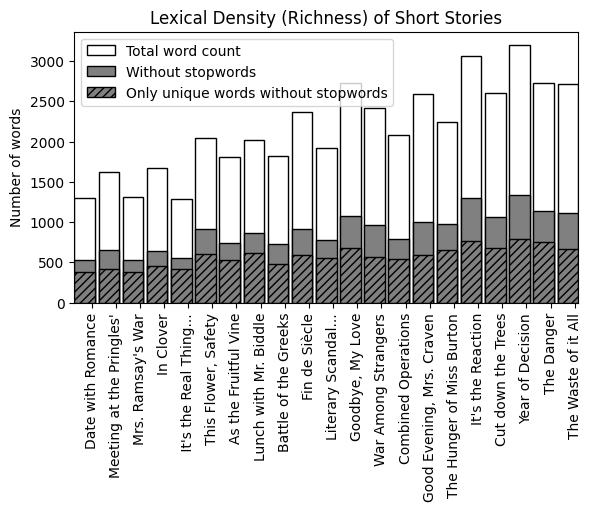

In [91]:
lengthes = [len(text) for text in texts]
unique_words_without_stops = [len(set(text)) for text in texts]
fig, ax = plt.subplots(constrained_layout=True, figsize=(5.8,5))
bar_width = 0.85
x = np.arange(len(titles_for_graphs))

rects1 = ax.bar(
    x - bar_width/3,
    compound_table['number of words'],
    width=bar_width,
    color='white',
    edgecolor = 'black',
    label='Total word count'
)

rects2 = ax.bar(
    x - bar_width/3,
    lengthes,
    width=bar_width,
    color='grey',
    edgecolor='black',
   
    label='Without stopwords'
)
rects3 = ax.bar(
    x - bar_width/3,
    unique_words_without_stops,
    width=bar_width,
    color='grey',
    edgecolor='black',
    hatch='////',
    label='Only unique words without stopwords'
)
ax.set_ylabel('Number of words')
ax.set_title('Lexical Density (Richness) of Short Stories')
ax.set_xticks(x)
ax.set_xticklabels(titles_for_graphs)
ax.legend()

plt.xticks(rotation=90)
plt.margins(x=0)
plt.savefig('figure 5.png', dpi=300)
plt.show()

In [77]:
texts = []
extra = ['the', 'and', 'for', 'a', 'of', 'to', 'in', 'be', 'I', 'that', 'it', 'have', 'she', 'her', 'he', 'say', 'mr', 'mrs', 'with',
'not', 'they', 'on', 'you', 'would', 'do', 'at', 'up', 'as', 's', 'will', 'out', 'his', 'but', '’s', 'from', 'miss', 'there', 'who',
'or', 'over', 'adrian', 'ruth', 'we', 'don', 'parmenter', 'walsingham', 'dossie', 'if', 'clark', 'margaret', 'by', 'vereker',
'twistle', 'their', 'peters', 'gerald', 'ramsay', 'fletcher', 'biddle', 'about', 'an', 'bristowe', 'down', 'dudley', 'jessie', 'lucy',
'janet', 'burton', 'ernestine', 'walter', 'marriot', 'could', 'which', 'like', 'trent', 'when', 'all', 'get', 'think', 'ewing', 'into',
'know', 'look', 'go', 'valerie', 'philip', 'only', 'after', 'off', 'so', 'rudd', 'come', 'now', 'one', 'what', 'feel', 'make',
'mark', 'my', 'this', 'craig', 'traver', 'some', 'more', 'jay', 'masters', 'take', 'raymond', 'though', 'back', 'roger', 'dora', 
'craven', 'gregory', 'dean', 'laura', 'merrill', "\'s", 'vyner', 'crumpington', 'pringle', "sysonby", "hunter", 'taylor', 'seem',
'spark', 'ewe', 'dear', 'tell']
for item in lemmatized_texts:
    texts.append([word for word in item if not word in extra and not word in english_stopwords])

#texts = [[word for word in word_tokenize(document.lower()) if word.isalnum()] for document in documents]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Обучение модели LDA
lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=30)

# Вывод топ-5 слов для каждой темы
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)


(0, '0.006*"little" + 0.005*"time" + 0.005*"good" + 0.005*"day" + 0.005*"well"')
(1, '0.010*"birch" + 0.005*"ow" + 0.005*"greek" + 0.004*"evening" + 0.004*"place"')
(2, '0.006*"little" + 0.005*"really" + 0.005*"good" + 0.005*"house" + 0.004*"woman"')
(3, '0.009*"major" + 0.004*"see" + 0.004*"war" + 0.004*"real" + 0.003*"evening"')
(4, '0.009*"room" + 0.007*"old" + 0.005*"day" + 0.005*"see" + 0.005*"war"')


In [78]:
lda_model = gensim.models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=30)

# Вывод топ-5 слов для каждой темы
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.008*"old" + 0.007*"little" + 0.007*"day" + 0.006*"good" + 0.006*"time"')
(1, '0.008*"old" + 0.006*"well" + 0.006*"monica" + 0.006*"helen" + 0.005*"good"')
(2, '0.010*"little" + 0.006*"ask" + 0.006*"yum" + 0.005*"home" + 0.004*"good"')
(3, '0.014*"birch" + 0.007*"house" + 0.006*"evening" + 0.004*"little" + 0.004*"woman"')
(4, '0.005*"little" + 0.005*"well" + 0.004*"time" + 0.004*"good" + 0.004*"room"')
(5, '0.012*"major" + 0.009*"war" + 0.006*"safe" + 0.005*"real" + 0.005*"day"')
(6, '0.000*"time" + 0.000*"little" + 0.000*"old" + 0.000*"day" + 0.000*"well"')
(7, '0.000*"room" + 0.000*"little" + 0.000*"old" + 0.000*"house" + 0.000*"war"')
(8, '0.011*"room" + 0.010*"prout" + 0.009*"carver" + 0.009*"child" + 0.007*"peake"')
(9, '0.008*"mason" + 0.007*"wednesday" + 0.007*"sea" + 0.006*"ask" + 0.006*"’m"')


In [79]:
lda_model = gensim.models.LdaModel(corpus, num_topics=15, id2word=dictionary, passes=30)

# Вывод топ-5 слов для каждой темы
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.000*"room" + 0.000*"day" + 0.000*"thing" + 0.000*"war" + 0.000*"little"')
(1, '0.006*"place" + 0.005*"face" + 0.005*"eat" + 0.005*"little" + 0.004*"madeline"')
(2, '0.013*"major" + 0.007*"war" + 0.007*"turn" + 0.006*"see" + 0.006*"time"')
(3, '0.013*"prout" + 0.013*"child" + 0.008*"tea" + 0.007*"well" + 0.007*"time"')
(4, '0.012*"birch" + 0.009*"evening" + 0.007*"good" + 0.007*"little" + 0.006*"old"')
(5, '0.013*"bus" + 0.010*"food" + 0.009*"wolf" + 0.007*"chocolate" + 0.007*"emil"')
(6, '0.000*"little" + 0.000*"war" + 0.000*"thing" + 0.000*"good" + 0.000*"time"')
(7, '0.010*"room" + 0.008*"little" + 0.008*"greek" + 0.008*"carver" + 0.006*"well"')
(8, '0.019*"france" + 0.009*"little" + 0.006*"day" + 0.006*"good" + 0.005*"farmer"')
(9, '0.006*"efficiently" + 0.005*"shelter" + 0.003*"miscarriage" + 0.003*"violent" + 0.003*"gather"')
(10, '0.000*"little" + 0.000*"well" + 0.000*"time" + 0.000*"room" + 0.000*"see"')
(11, '0.006*"house" + 0.006*"time" + 0.005*"well" + 0.005*"day" + 0.

In [80]:
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.enable_notebook()
vis

/home/felix/miniconda3/envs/mollie/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:37: DeprecationWarning: This process (pid=1878) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/felix/miniconda3/envs/mollie/lib/python3.12/site-packages/joblib/_utils.py:37: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/home/felix/miniconda3/envs/mollie/lib/python3.12/site-packages/joblib/_utils.py:37: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/home/felix/miniconda3/envs/mollie/lib/python3.12/site-packages/joblib/_utils.py:37: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/home/felix/miniconda3/envs/mollie/lib/python3.12/site-package

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.103937  0.029915       1        1  25.436089
4     -0.132035  0.046335       2        1  15.777199
14    -0.126660  0.055080       3        1  15.751452
8     -0.109262  0.010494       4        1  10.320550
7     -0.102541 -0.082426       5        1  10.298419
1     -0.086067 -0.184251       6        1   9.086375
3     -0.106823  0.076737       7        1   6.479935
2      0.021161  0.061456       8        1   4.250277
5      0.166063  0.017855       9        1   2.039611
12     0.114739 -0.002928      10        1   0.334856
9      0.107995 -0.008932      11        1   0.195157
0      0.089349 -0.004835      12        1   0.007520
6      0.089349 -0.004837      13        1   0.007520
10     0.089335 -0.004834      14        1   0.007520
13     0.089334 -0.004829      15        1   0.007520, topic_info=        Term       Freq      Total Category  logprob  loglift
1330  france  39.000000  39.000000  Default  30.0000  30.0000
3870   birch  34.000000  34.000000  Default  29.0000  29.0000
440    child  50.000000  50.000000  Default  28.0000  28.0000
3309   prout  15.000000  15.000000  Default  27.0000  27.0000
1374   major  14.000000  14.000000  Default  26.0000  26.0000
...      ...        ...        ...      ...      ...      ...
1330  france   0.000291  39.742749  Topic15  -8.4781  -2.3297
726       ’m   0.000291  33.107233  Topic15  -8.4782  -2.1471
379     year   0.000291  41.138176  Topic15  -8.4782  -2.3643
834    house   0.000291  70.436726  Topic15  -8.4782  -2.9021
215     must   0.000291  40.668185  Topic15  -8.4783  -2.3529

[971 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1791      6  0.690968       \n 
3203      7  0.770543        17
1245      8  0.820944    absent
2         1  0.398836  absently
2         2  0.398836  absently
...     ...       ...       ...
726       3  0.090615        ’m
726       4  0.030205        ’m
726       5  0.090615        ’m
726       6  0.120820        ’m
726       7  0.181229        ’m

[1498 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 5, 15, 9, 8, 2, 4, 3, 6, 13, 10, 1, 7, 11, 14])